## CIFAR10 Dataset 시각화

In [1]:
import os, copy
# root_dir = "/content/MixMatch" # PROJECT Directory
root_dir = "./MixMatch"
data_dir = os.path.join(root_dir, 'data') # Data Directory
os.makedirs(data_dir, exist_ok=True)

#### 필요한 패키지 부르기

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### torchvision.datasets.CIFAR10 다운로드 및 시각화
#### 예제 이미지 시각화

In [3]:
def visualization(img,
                  m=(0.4914, 0.4822, 0.4465),
                  std=(0.2471, 0.2345, 0.2616)):
  for i in range(3):
    img[i, :, :] = img[i, :, :] * std[i] + m[i]
  
  img_np = img.numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(np.transpose(img_np, (1, 2, 0)))

#### Python 내장함수인 next(), iter() 에 대해 알아보기
##### iter는 반복 가능한 객체(ex, list())에서 iterator를 반환
##### next는 반복 가능한 객체에서 iterator 값을 순차적으로 반환

In [4]:
a = ['1905', '2002', '2012', '2019', '2022']
print(a)

['1905', '2002', '2012', '2019', '2022']


In [5]:
it = iter(a)
next(it)

'1905'

In [6]:
next(it)

'2002'

#### 학습용 이미지를 무작위로 가져오기

In [7]:
transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                           std=(0.2471, 0.2345, 0.2616))
    ]
)

batch_size = 4

train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2) # DataLoader는 batch_size만큼 데이터를 메모리에 Load하는 역할
                                                                        # Load: 데이터를 RAM에 올려 놓고 연산가능하도록 하는 작업

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:16<00:00, 10507846.67it/s]


Extracting ./MixMatch/data/cifar-10-python.tar.gz to ./MixMatch/data


In [8]:
iter_data = iter(train_loader) # 데이터를 무작위로 Load해주는 DataLoader -> 반복가능한 객체
imgs, labels = next(iter_data) # 무작위 순서 내 다음 순서를 반환하는 역할

In [9]:
labels

tensor([9, 3, 1, 0])

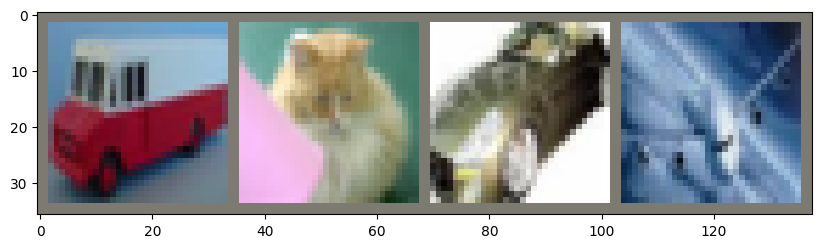

In [10]:
visualization(torchvision.utils.make_grid(imgs))

In [11]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

truck cat   car   plane


## Data Augmentation and Two augmenations

#### torchvision transform documentation
#### https://pytorch.org/vision/stable/transforms.html

<img src='image/img1.png' width='800'></img>

In [12]:
class Transform_Twice:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, img):
        out1 = self.transform(img)
        out2 = self.transform(img)
        return out1, out2

In [13]:
twice_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                          std=(0.2471, 0.2345, 0.2616))
])

train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=Transform_Twice(twice_transform))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2) 

Files already downloaded and verified


In [14]:
iter_data = iter(train_loader) # 데이터를 무작위로 Load해주는 DataLoader -> 반복가능한 객체
(imgs_aug1, imgs_aug2), labels = next(iter_data) # 무작위 순서 내 다음 순서를 반환하는 역할

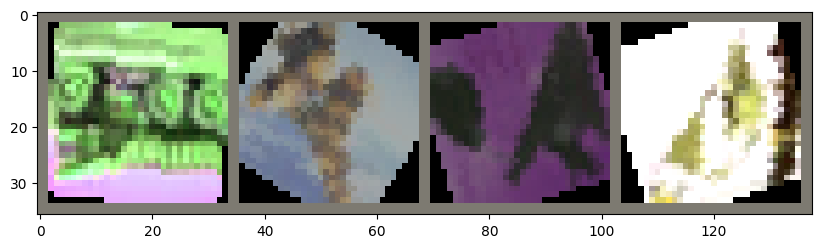

In [15]:
visualization(torchvision.utils.make_grid(imgs_aug1))

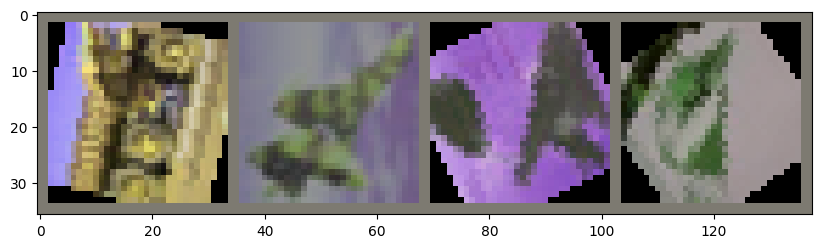

In [16]:
visualization(torchvision.utils.make_grid(imgs_aug2))

In [17]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

truck plane plane bird 


## MixUp algorithm (https://arxiv.org/abs/1710.09412)
#### single labels to one-hot encoding

<img src='image/img2.png' width='800'></img>

In [18]:
labels

tensor([9, 0, 0, 2])

In [19]:
labels_onehot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1,1).long(), 1)

In [20]:
labels_onehot

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

#### MixUp with imgs_aug1 and imgs_aug2
#### imgs aug2 are randomly permuted

<img src='image/img3.png' width='500'></img>

In [21]:
l_mixup = np.random.beta(0.75, 0.75)
l_mixup = max(l_mixup, 1-l_mixup)
print(l_mixup)

0.9942260345022614


In [22]:
B = imgs_aug2.size(0)
random_idx = torch.randperm(B)

imgs_aug2 = imgs_aug2[random_idx, :, :, :]
labels_aug2 = copy.deepcopy(labels_onehot)

In [23]:
labels_aug2 = labels_aug2[random_idx, :]

In [24]:
labels_aug2

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [25]:
labels_onehot

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

<img src='image/img4.png' width='800'></img>

In [26]:
mixed_input = l_mixup*imgs_aug1 + (1-l_mixup)*imgs_aug2
mixed_labels = l_mixup*labels_onehot + (1-l_mixup)*labels_aug2

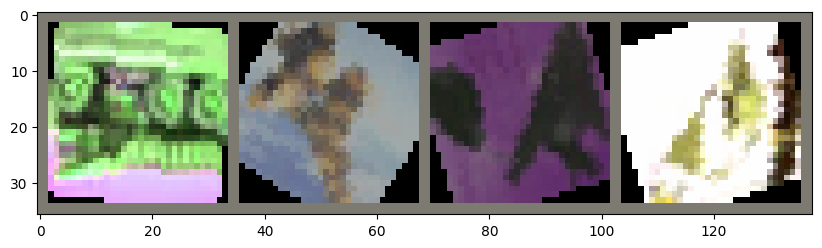

In [27]:
visualization(torchvision.utils.make_grid(mixed_input))

In [28]:
mixed_labels

tensor([[0.0058, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.9942],
        [0.9942, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0058],
        [0.9942, 0.0000, 0.0058, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0058, 0.0000, 0.9942, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])